In [3]:
import pandas as pd
import numpy as np
from IPython.display import Image
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from itertools import combinations
from collections import Counter

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report

import plotly.graph_objs as go
import plotly.plotly as py
from plotly.graph_objs import *

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [4]:
!ls ../data/

database.sqlite             fatality_facts_nona_two.csv
fatality_facts_nona.csv


In [5]:
fatal_nona_two = pd.read_csv('../data/fatality_facts_nona_two.csv',  index_col=0)

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [6]:
fatal_nona_two.shape

(1069871, 244)

In [7]:
# These are the continuous and categorical columns.
# This code was used in the encoding to create the imported csv file above; keeping for tracking purposes
encode_columns = ['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex']

continuous_columns = ['dof1','dvest','dvtotal','age','height','weight',
                     'gad1_B', 'gad1_F','gad1_L', 'gad1_R', 'gad1_T', 'gad1_U']

In [8]:
# X features dropping the target and all features that get dummies were performed on
y = fatal_nona_two['injsev']
X = fatal_nona_two.copy().drop(['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)

In [9]:
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2]) # 3 class output
n_classes = y.shape[1] # shape = (1069871, 3)

# creating the test train split for multiclass modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    stratify=fatal_nona_two['injsev'])

# Instantiate the Decission Tree Classifier
dt = DecisionTreeClassifier(min_samples_leaf=10)

classifier = OneVsRestClassifier(dt.fit(X_train, y_train))
y_score = classifier.fit(X_train, y_train).predict(X_test)

In [10]:
# Compute ROC curve and ROC area for each class
fpr = {}  # false-positive rate
tpr = {}  # true-positive rate
roc_auc = {} # area under the curve score
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

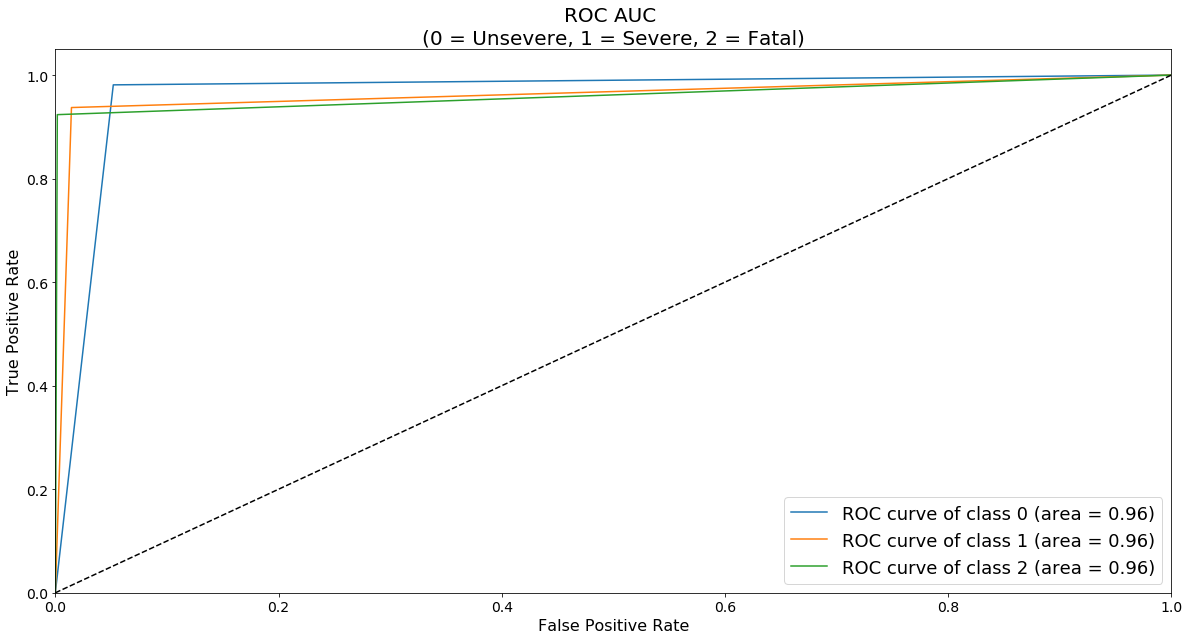

In [11]:
plt.figure(figsize=(20,10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC AUC \n(0 = Unsevere, 1 = Severe, 2 = Fatal)', fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.show()

In [12]:
feature_import = pd.concat([pd.Series(X_train.columns),
                            pd.Series(dt.feature_importances_.tolist())],
                           axis=1).sort_values(1,ascending=False)
feature_import.reset_index(level=0, drop=True, inplace=True)
feature_import.columns = ['feature','importance']

In [13]:
feature_import.set_index('feature', inplace=True)

Text(0.5,0,'Features')

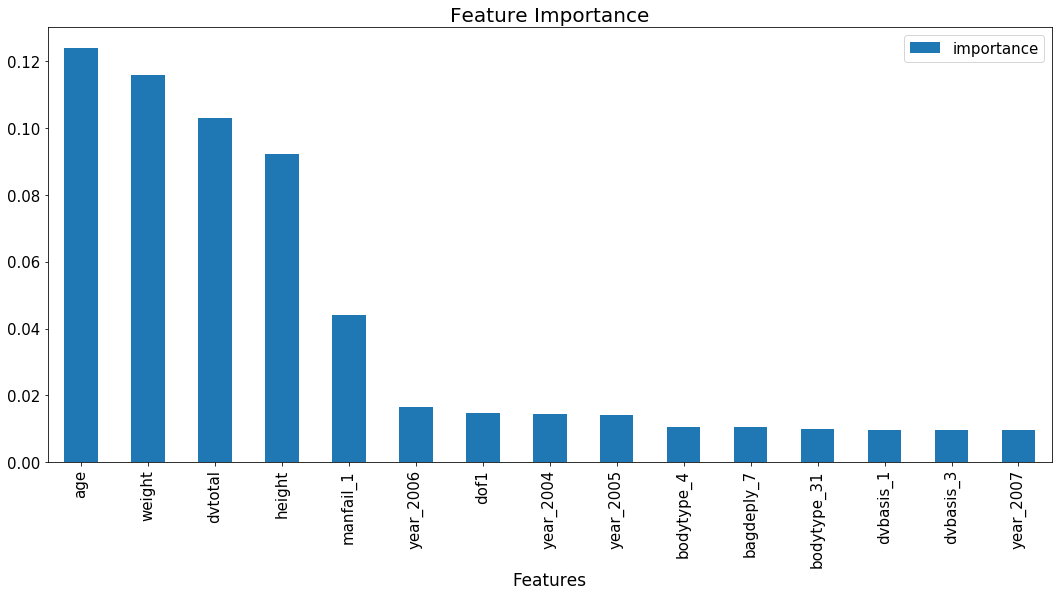

In [14]:
# Plotting the feature importances
plt.figure(figsize=(20,13))
feature_import.iloc[:15].plot(kind='bar', 
                    fontsize=15, figsize=(18,8))
plt.legend(fontsize=15)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=17)

In [15]:
print(classification_report(y_test, y_score))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98    157950
          1       0.95      0.94      0.94     49835
          2       0.94      0.92      0.93      6190

avg / total       0.97      0.97      0.97    213975



### Minority Class Oversampling

In [16]:
classes = ['unsevere', 'severe', 'fatal']
for i,c in enumerate(classes):
    print('({}){} total: {} instances'.format(i, c, fatal_nona_two['injsev'].value_counts()[i]))

(0)unsevere total: 789748 instances
(1)severe total: 249175 instances
(2)fatal total: 30948 instances


In [17]:
# Changed the name of X and y so there is no conficts with them assigned above
y_2 = fatal_nona_two['injsev']
X_2 = fatal_nona_two.copy().drop(['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)

In [32]:
# Train / Test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.33, random_state=42)

# Intantiate the Random Over Sampler
ros = RandomOverSampler(ratio='auto', random_state=42) # 'auto' --> oversampled target to achieve balanced classes

# Fit X_train and y_trian into the oversampling algorithm
X_train_ros, y_train_ros = ros.fit_sample(X_train_2, y_train_2)

In [33]:
# Binarize the output
y_train_2_b = label_binarize(y_train_ros, classes=[0, 1, 2]) # 3 class output (train)
y_test_2_b = label_binarize(y_test_2, classes=[0, 1, 2]) # 3 class output (test)
n_classes = y_train_2_b.shape[1] # shape = (1069871, 3)

In [42]:
# Training data before and after Random Sampling
print('Before Random Sampling: {}'.format(Counter(y_train_2)))
print('After Random Sampling: {}'.format(Counter(y_train_ros)))  

Before Random Sampling: Counter({0: 529012, 1: 166986, 2: 20815})
After Random Sampling: Counter({0: 529012, 1: 529012, 2: 529012})


In [35]:
# Instantiate the Decission Tree Classifier
dt_2 = DecisionTreeClassifier(min_samples_leaf=10)

classifier = OneVsRestClassifier(dt_2.fit(X_train_ros, y_train_2_b))
y_score = classifier.fit(X_train_ros, y_train_2_b).predict(X_test_2)

In [36]:
# Compute ROC curve and ROC area for each class
fpr = {}  # false-positive rate
tpr = {}  # true-positive rate
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i],_= roc_curve(y_test_2_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

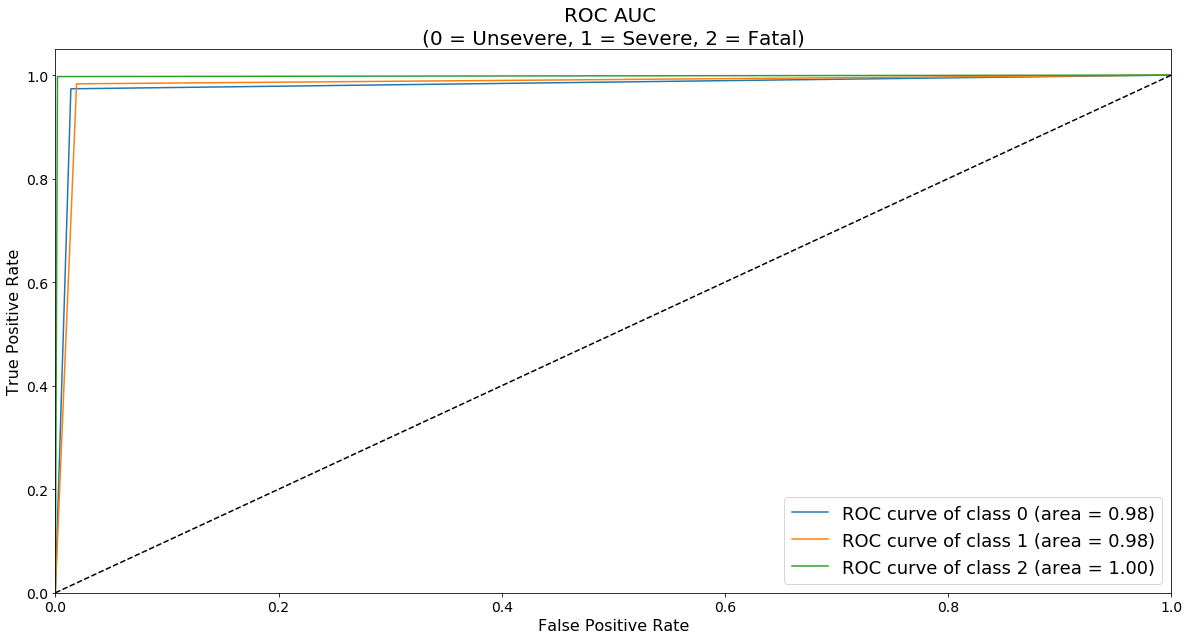

In [37]:
plt.figure(figsize=(20,10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC AUC \n(0 = Unsevere, 1 = Severe, 2 = Fatal)', fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.show()

In [38]:
# Oversampling decreased 'Fatal (2)' precision, but increased sensitivity.  
print(classification_report(y_test_2_b, y_score))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98    260736
          1       0.94      0.98      0.96     82189
          2       0.94      1.00      0.97     10133

avg / total       0.98      0.98      0.98    353058



In [39]:
feature_import = pd.concat([pd.Series(X_train_2.columns),
                            pd.Series(dt_2.feature_importances_.tolist())],
                           axis=1).sort_values(1,ascending=False)
# feature_import.reset_index(level=0, drop=True, inplace=True)
feature_import.columns = ['feature','importance']
feature_import.set_index('feature', inplace=True)

TypeError: hlines() missing 2 required positional arguments: 'xmin' and 'xmax'

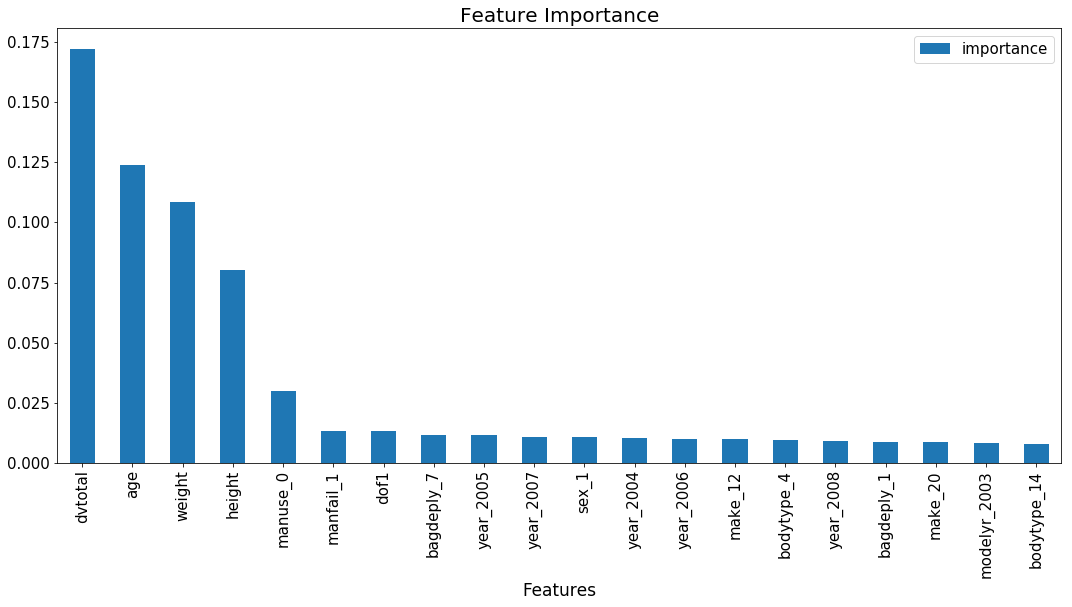

In [63]:
# Plotting the feature importances
plt.figure(figsize=(20,13))
feature_import.iloc[:20].plot(kind='bar', 
                    fontsize=15, figsize=(18,8))
plt.legend(fontsize=15)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=17)
plt.hlines( )

### Feature Definitions
- **dvtotal**:  total delta velocity [kph]
- **age**: occupant age
- **weight**: occupant weight
- **height**: occupant height
- **manuse_0**: no seatbelt used
- **manfail_1**:  no seatbelt malfunction
- **bagdeply_7**:  air bag did not deploy
- **sex_1**:  male
- **make_12**: Ford
- **bodytpe_4**:  4-door sedan
- **bagdeply_1**:  air bag deployed on impact
- **make_20**: Chevrolet
- **bodytype_14**: compact SUV (examples: 4-Runner, Cherokee, Explorer)

In [92]:
# instances for each year plays a part on feature importance along with the resampling affects (see year_2007)
year_data = pd.DataFrame(fatal_nona_two['year'].value_counts())
year_data.columns = ['count']
# year_data.sort_index(ascending=True)
year_data

,count
2004,258617
2006,231775
2005,222090
2007,103224
2008,77596
2009,49706
2010,37825
2011,35255
2014,24737
2012,20102
